In [1]:
#Importing packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from bayes_opt import BayesianOptimization
from sklearn.impute import SimpleImputer
import lightgbm

In [2]:
#Loading the files Xtrain_scaled_pca, Xtest_scaled_pca, Ytrain, Ytest from the 
#preprocessing notebook.

folder_path = '/kaggle/input/rsna-breast-cancer-detection-preprocessing-2/'

with open(folder_path + 'Xtest_scaled_pca.pickle', 'rb') as file:
    Xtest_scaled_pca = pickle.load(file)
with open(folder_path + 'Xtrain_scaled_pca.pickle', 'rb') as file:
    Xtrain_scaled_pca = pickle.load(file)
with open(folder_path + 'Ytest.pickle', 'rb') as file:
    Ytest = pickle.load(file)
with open(folder_path + 'Ytrain.pickle', 'rb') as file:
    Ytrain = pickle.load(file)

# Logistic Regression

Let's first use logistic regression. We will use Bayesian optimization to do the hyperparameter search. We will use the F1-score as the evaluation metric, because we want to minimize the number of false positives.

In [3]:
def logreg_eval(C):
    logreg = LogisticRegression(solver = 'liblinear', max_iter = 500, C=C)
    cv_results = cross_val_score(logreg, Xtrain_scaled_pca, Ytrain, scoring="f1",cv=5)
    return cv_results.mean()

In [4]:
logregBO = BayesianOptimization(logreg_eval, {'C': (0.01,200)})
logregBO.maximize(init_points=5,n_iter=10,acq='ucb')

|   iter    |  target   |     C     |
-------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  


| 1         | 0.9535    | 139.2     |
| 2         | 0.9535    | 194.5     |
| 3         | 0.9535    | 183.8     |
| 4         | 0.9538    | 15.29     |
| 5         | 0.9535    | 171.8     |
| 6         | 0.9459    | 0.01312   |
| 7         | 0.9538    | 13.56     |
| 8         | 0.9535    | 154.8     |
| 9         | 0.9535    | 124.4     |
| 10        | 0.9535    | 109.6     |
| 11        | 0.9535    | 94.91     |
| 12        | 0.9538    | 80.27     |
| 13        | 0.9538    | 67.56     |
| 14        | 0.9538    | 54.36     |
| 15        | 0.9538    | 41.07     |


We see that the F1-score doesn't vary much over the whole range of C, and stays at around 0.95. Let's now choose the value C=38.05 and make predictions on the test set.

In [5]:
logreg = LogisticRegression(solver = 'liblinear', max_iter = 500, C=38.05)
logreg.fit(Xtrain_scaled_pca, Ytrain)
print(f'F1-score on training data: {f1_score(logreg.predict(Xtrain_scaled_pca), Ytrain):.2f}')
print(f'F1-score on test data: {f1_score(logreg.predict(Xtest_scaled_pca), Ytest):.2f}')

F1-score on training data: 0.96
F1-score on test data: 0.64


# Random Forest

Next, we try random forest. We go back to using GridSearchCV because we want to optimize over discrete (integer) values of the parameter min_samples_split, and it's hard to deal with discrete hyperparameter values with BayesianOptimization.

In [6]:
rf = RandomForestClassifier(random_state=47, n_estimators=8, n_jobs=-1)
parameters = {"min_samples_split": [3,4],
             "max_depth": [2,3],
             "criterion": ["gini","entropy"],
             "max_features": ["sqrt", "log2", None],
             "bootstrap": [True, False]}

cv_rf = RandomizedSearchCV(rf, param_distributions=parameters, scoring='f1', cv=5, 
                           random_state=13, n_jobs=-1)

Printing the best parameter value and the best F1-score of the train set:

In [7]:
cv_rf.fit(Xtrain_scaled_pca, Ytrain)
print(cv_rf.best_score_)
print(cv_rf.best_params_)

0.7504223587167486
{'min_samples_split': 3, 'max_features': 'log2', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}


Printing the F1-score on the test set:

In [8]:
Ypred = cv_rf.predict(Xtest_scaled_pca)
print("F1-score of the test set:", f1_score(Ytest, Ypred))

F1-score of the test set: 0.2570162481536189


Unfortunately, the F1-score of the test set is much lower than the one of the train set.

# Gradient boosting

In [9]:
gb = GradientBoostingClassifier(random_state=47, n_estimators=8)
parameters = {"learning_rate": [0.2,0.5,1],
             "min_samples_split": [3,4],
             "max_depth": [2,3],
             "criterion": ["friedman_mse", "squared_error"],
             "max_features": ["auto", "sqrt", "log2", None]}

cv_gb = RandomizedSearchCV(gb, param_distributions=parameters, scoring='f1', cv=5, 
                           random_state=13, n_jobs=-1)

Printing the best parameter value and the best F1-score of the train set:

In [10]:
cv_gb.fit(Xtrain_scaled_pca, Ytrain)
print(cv_gb.best_score_)
print(cv_gb.best_params_)

0.8588718294518725
{'min_samples_split': 3, 'max_features': None, 'max_depth': 3, 'learning_rate': 1, 'criterion': 'squared_error'}


Printing the F1-score on the test set:

In [11]:
Ypred = cv_gb.predict(Xtest_scaled_pca)
print("F1-score of the test set:", f1_score(Ytest, Ypred))

F1-score of the test set: 0.3469079939668175


Again, the F1-score of the test set is considerably lower than the one of the train set.

Overall, it looks like logistic regression is the best algorithm.

# ROC-AUC for Logistic Regression

Even though our metric has been chosen to be the F1-score, it's useful to produce the ROC curve and compute the AUC metric for our best algorithm - logistic regression.

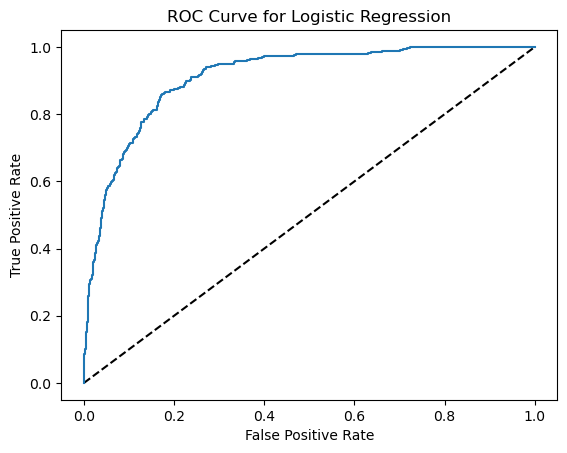

In [12]:
Ypred_probs = logreg.predict_proba(Xtest_scaled_pca)[:,1]
fpr, tpr, thresholds = roc_curve(Ytest, Ypred_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.show()

In [13]:
#Print out the area under the curve.
print(auc(fpr, tpr))

0.9113897978446553


Let's also plot the false positive rate as a function of the threshold.

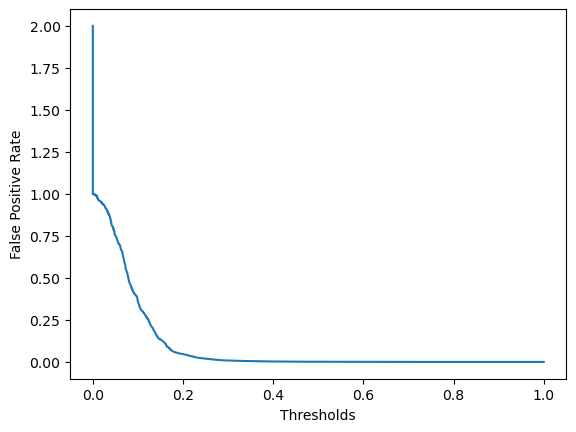

In [14]:
plt.plot(fpr, thresholds)
plt.xlabel('Thresholds')
plt.ylabel('False Positive Rate')
plt.show()

We see that the usual threshold of 0.5 corresponds to an excellent FPR, which is much smaller than the largest acceptable FPR of 25 percent (which we demand at the beginning of the project, in the Project Proposal).